# Loan Status Prediction

## Introduction


In this project, I predictive modelling in order to understand how different set of features help to indentify
customer loan status. 

## ETL Pipline

1. **Data Cleaning**:

    * Drop irrelevant features
    * Clean mixed type features
    * ....

2. **Exploratory Analysis**


3. **Machine Learning** 


### Import Libraries

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
warnings.filterwarnings("ignore")

## Loan Data

In [58]:
df_orig = pd.read_csv("data/loan.csv",low_memory=False,skiprows=1)

In [85]:
df = df_orig

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99998 entries, 0 to 99997
Columns: 145 entries, id to settlement_term
dtypes: float64(67), int64(41), object(37)
memory usage: 110.6+ MB


In [87]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,24700,24700,24700,36 months,11.99%,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,17925,17925,17925,60 months,17.27%,448.09,D,D3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,9000,9000,9000,36 months,8.49%,284.07,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,11550,11550,11550,60 months,16.59%,284.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,12000,12000,12000,60 months,9.80%,253.79,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
df.shape

(99998, 145)

There are 145 features and most of them are irrelevant. So we keep most important features for further processing.

In [89]:
keep_cols = ["loan_status","loan_amnt", "term","int_rate","installment","grade",
             "sub_grade", "emp_length","home_ownership","annual_inc",
             "verification_status","issue_d","dti","earliest_cr_line","open_acc",
             "revol_bal","revol_util","total_acc"]
df = df[keep_cols]

### Fix Target Feature

In [90]:
# simplify target feature
df.loan_status.unique()

array(['Fully Paid', 'Current', 'Charged Off', 'Late (16-30 days)',
       'Late (31-120 days)', 'In Grace Period', 'Default'], dtype=object)

Target feature 'loan_status' has 7 factors. We will reduce it to two 'Good' and 'Bad' loans.

In [91]:
good_loans = ['Fully Paid', 'Current']

def LoanCondition(status):
    if status in good_loans:
        return 'Good Loan'
    else:
        return 'Bad Loan'

tmp = df['loan_status'].apply(LoanCondition)
df.loan_status = tmp

### Clean Features

Some features have mixed type such as number mixed with string.

* Remove '%' from 'int_rate', 'revol_util' 
* Replace all 'n/a' with np.nan
* 

In [66]:
def CleanData(df):
    """
    
    """
    
    #rm '%' and convert to float
    df.int_rate = pd.Series(df.int_rate).str.replace('%', '').astype(float)
    df.revol_util = pd.Series(df.revol_util).str.replace('%', '').astype(float)
    
    df.replace('n/a', np.nan,inplace = True)
    df.emp_length.fillna(value = 0,inplace = True)
    
    df['emp_length'].replace(to_replace = '[^0-9]+', value='', inplace = True, regex = True)
    df['emp_length'] = df['emp_length'].astype(int)
    
    issue_month = df.issue_d.str.replace('-2015', '')
    df['issue_month'] = pd.Series( issue_month, index=df.index)
    
    df.term = pd.Series(df.term).str.replace('months', '').astype(int)
    
    df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)
    df.issue_d = pd.to_datetime(df.issue_d)
    
    cred_age = df.issue_d - df.earliest_cr_line
    df['cred_age'] = pd.Series( cred_age, index=df.index)
        
    tmp = np.rint(df['cred_age'].map(lambda x: x.days/365))
    df['cred_age'] = pd.Series( tmp, index=df.index)

    df.drop(columns="issue_d",inplace=True)
    df.drop(columns="earliest_cr_line",inplace=True)
    
    return df

    

In [67]:
df = CleanData(df)

In [45]:
#df['cred_age'] = pd.Series( tmp, index=df.index)    

In [ ]:
#df_orig.purpose.value_counts()

In [97]:
df.sub_grade

In [ ]:
df.emp_length

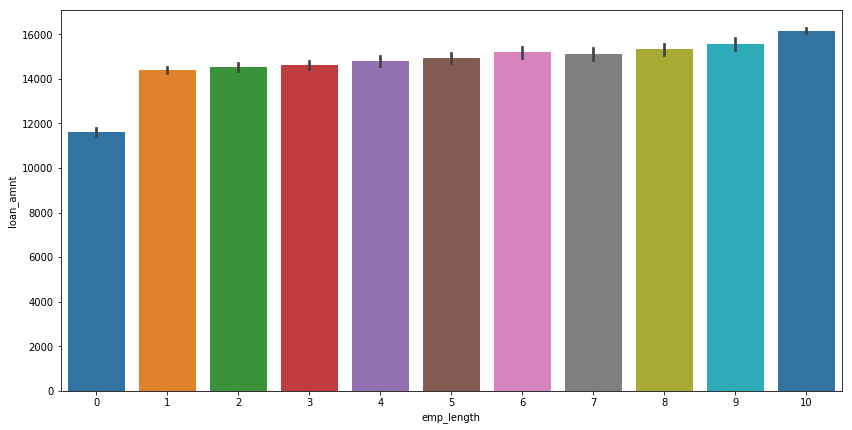

In [72]:
plt.figure(figsize=(14,7))
sns.barplot('emp_length', 'loan_amnt', data=df, palette='tab10')

[Text(0, 0.5, '(%)')]

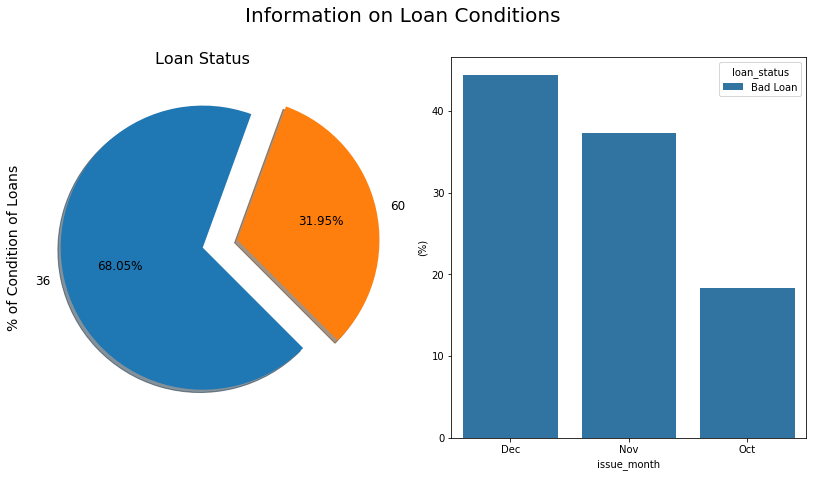

In [77]:
f, ax = plt.subplots(1,2, figsize=(14,7))

#colors = ["#3791D7", "#D72626"]

labels =['Fully Paid', 'Current', 'Charged Off', 'Late16-30days']

plt.suptitle('Information on Loan Conditions', fontsize=20)

df["term"].value_counts().plot.pie(explode=[0,0.25],
                                          autopct='%1.2f%%',
                                          ax=ax[0],
                                          shadow=True,
                                          #colors=colors,
                                          #labels=labels,
                                          fontsize=12,
                                          startangle=70)

ax[0].set_title('Loan Status', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)


sns.barplot(x="issue_month", y="loan_amnt", hue="loan_status",
            data=df, #palette=palette,
            estimator=lambda x: len(x) / len(df) * 100)

ax[1].set(ylabel="(%)")

In [23]:
df.loan_status.unique()

array(['Fully Paid', 'Current', 'Charged Off', 'Late (16-30 days)',
       'Late (31-120 days)', 'In Grace Period', 'Default'], dtype=object)

In [29]:
df[(df.loan_status == 'Current') | (df.loan_status == 'Fully Paid')].loan_status = "GoodLoan"

In [30]:
df.head()

,loan_status,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,dti,open_acc,revol_bal,revol_util,total_acc,issue_month,cred_age
0,Fully Paid,24700,36,11.99,820.28,C,C1,10,MORTGAGE,65000.0,Not Verified,16.06,22,21470,19.2,38,Dec,16.0
1,Current,17925,60,17.27,448.09,D,D3,10,OWN,39000.0,Source Verified,27.78,10,19614,76.0,21,Dec,13.0
2,Fully Paid,9000,36,8.49,284.07,B,B1,8,MORTGAGE,47000.0,Not Verified,8.43,12,9747,26.7,22,Dec,15.0
3,Charged Off,11550,60,16.59,284.51,D,D2,5,RENT,38000.0,Not Verified,21.07,9,7179,39.7,12,Dec,5.0
4,Fully Paid,12000,60,9.80,253.79,B,B3,10,MORTGAGE,65000.0,Not Verified,23.84,18,9786,13.4,37,Dec,12.0
